In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from netCDF4 import num2date
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

In [11]:
print(datetime.now().year+5)

2021


In [2]:
ncss = NCSS('http://nomads.ncdc.noaa.gov/thredds/ncss/grid/narr-a/198106/19810619/narr-a_221_19810619_1200_000.grb')

In [3]:
query = ncss.query()
query.all_times().variables('Pressure_reduced_to_MSL').add_lonlat().accept('netcdf4')
data = ncss.get_data(query)

In [4]:
lats = data.variables['y']
lons = data.variables['x']
mslp = data.variables['Pressure_reduced_to_MSL'][:]/100.

In [5]:
crs = ccrs.LambertConformal(central_latitude=45., central_longitude=-100.)
globe = ccrs.Globe(datum='WGS84',ellipse='sphere')
#crs = ccrs.PlateCarree()
clons, clats = np.meshgrid(lons[:]*1000.,lats[:]*1000.)
tlatslons = crs.transform_points(ccrs.LambertConformal(central_latitude=50.,central_longitude=-107.,
                                                       standard_parallels=(50.,50.),globe=globe),clons,clats)
tlats = tlatslons[:,:,1]
tlons = tlatslons[:,:,0]

//anaconda/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


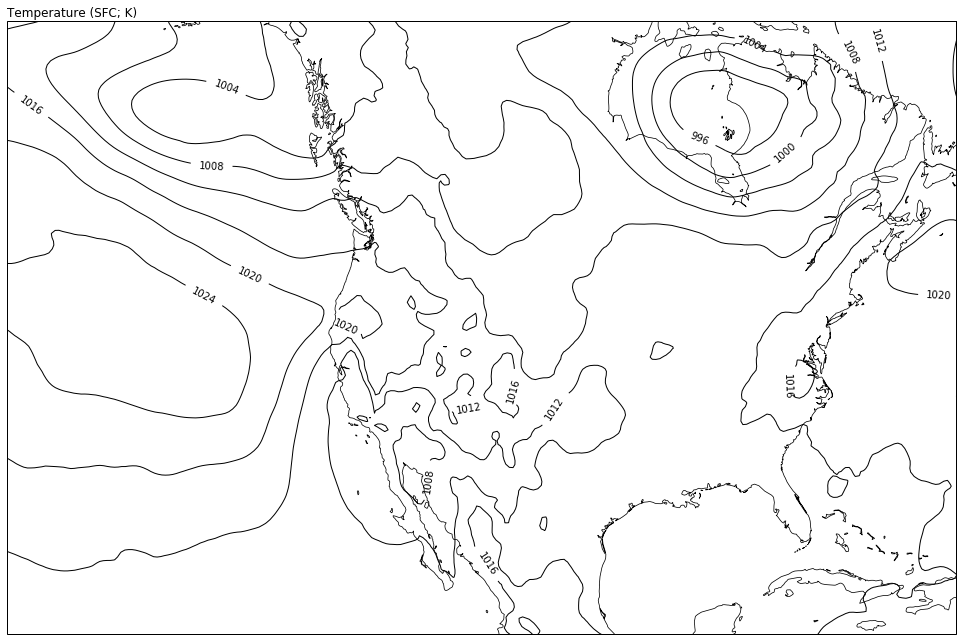

In [6]:
%matplotlib inline
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(17.,11.))
ax=plt.subplot(111,projection=crs)
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-145.,-70,20.,60.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
#ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
clevmslp = np.arange(800.,1120.,4)
cs = ax.contour(tlons[:,:],tlats[:,:],mslp[FH,:,:],clevmslp,colors='k',linewidths=1.0,linestyles='solid')
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)
#ut, vt = crs.transform_vectors(ccrs.LambertConformal(central_latitude=50.,central_longitude=-107.),
#                                                     clons,clats,uwnd[FH,6,:,:],vwnd[FH,6,:,:])
#ax.barbs(tlons,tlats,ut,vt,length=6,regrid_shape=20)
#cf = ax.contourf(tlons,tlats,tmpk[FH,:,:],range(270,320,1),cmap=plt.cm.jet)
plt.title('Temperature (SFC; K)',loc='left')
#plt.title('VALID: %s' %(vtimes[FH]),loc='right')
plt.show()

In [7]:
def max_points(data,nsize):
    from scipy.ndimage.filters import maximum_filter,gaussian_filter
    
    smooth_data = gaussian_filter(data,1)
    data_max = maximum_filter(smooth_data, nsize, mode='nearest')
    data_max_alt = maximum_filter(data, nsize, mode='nearest')
    mxpoints = np.where(data_max == smooth_data)
    mxpoints_alt = np.where(data_max_alt == data)
    return mxpoints

def min_points(data,nsize):
    from scipy.ndimage.filters import minimum_filter,gaussian_filter
    
    smooth_data = gaussian_filter(data,1)
    data_min = minimum_filter(smooth_data, nsize, mode='nearest')
    mnpoints = np.where(data_min == smooth_data)
    return mnpoints

In [8]:
maxy,maxx = max_points(mslp[0,:,:],50)
miny,minx = min_points(mslp[0,:,:],50)

In [9]:
def plot_HILO_points(dlons,dlats,data,hilo,nsize):
    '''
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    is designed to plot an 'H' for maximum values (e.g., High pressure) and an 'L' for minimum
    values (e.g., low pressue). It first uses a one standard deviation gaussian filter to find
    a synoptic scale HILO value, then uses the scipy.ndimage filters for maximum or minimum values,
    finally the HILO symbol is plotted on the current axes with the smoothed integer value of the HILO.
    
    dlons = plotting longitude values (2D)
    dlats = plotting latitude values (2D)
    data = 2D data that you wish to plot the HILO placement
    hilo = Either a value of 'hi' for Maximum Values or 'lo' for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    
    The H and L symbol will be plotted on the current axes within the bounding frame (e.g., clip_on=True)
    '''
    from scipy.ndimage.filters import maximum_filter,gaussian_filter,minimum_filter
    
    smooth_data = gaussian_filter(data,0.5)
    dist = np.abs(dlats[0,0]-dlats[1,0])
    if (hilo == 'hi'):
        data_ext = maximum_filter(smooth_data, nsize, mode='nearest')
        txt_ext = 'H'
        color = 'b'
    elif (hilo == 'lo'):
        data_ext = minimum_filter(smooth_data, nsize, mode='nearest')
        txt_ext = 'L'
        color = 'r'
    mxy, mxx = np.where(data_ext == smooth_data)
    for i in range(len(mxy)):
        ax.text(dlons[mxy[i],mxx[i]],dlats[mxy[i],mxx[i]],txt_ext,color=color, size=18, clip_on=True)
        ax.text(dlons[mxy[i],mxx[i]]-dist*2,dlats[mxy[i],mxx[i]]-dist*3.5,np.int(smooth_data[mxy[i],mxx[i]]),
                color='k', size=11, clip_on=True, fontweight='bold')

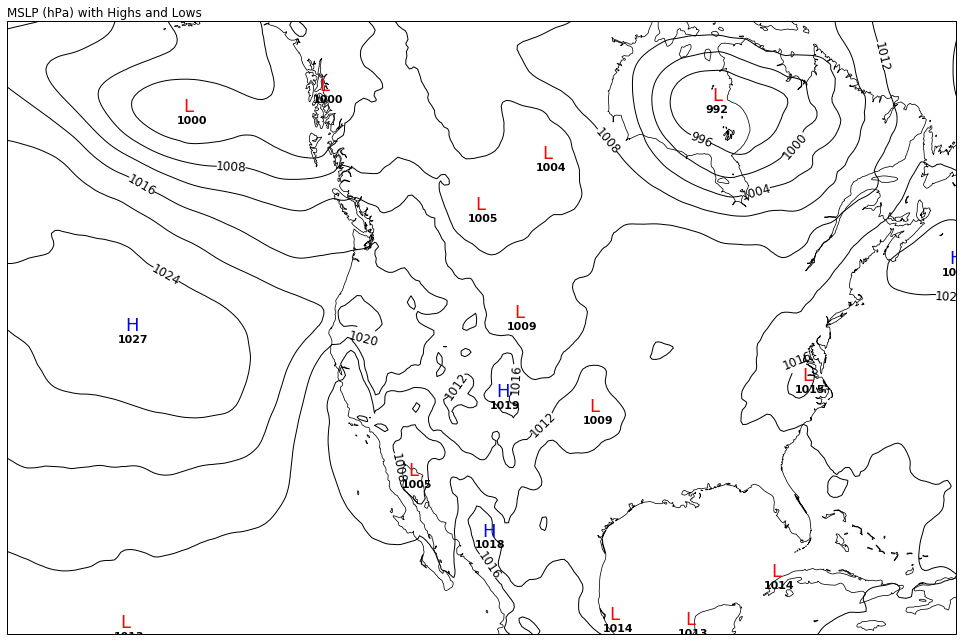

In [10]:
%matplotlib inline
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(17.,11.))
ax=plt.subplot(111,projection=crs)
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-145.,-70,20.,60.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
#ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
clevmslp = np.arange(800.,1120.,4)
cs = ax.contour(tlons[:,:],tlats[:,:],mslp[FH,:,:],clevmslp,colors='k',linewidths=1.0,linestyles='solid')
plt.clabel(cs, fontsize=12, inline=1, inline_spacing=0, fmt='%i', rightside_up=True, use_clabeltext=True)
plot_HILO_points(tlons,tlats,mslp[0,:,:],'hi',50)
plot_HILO_points(tlons,tlats,mslp[0,:,:],'lo',25)

plt.title('MSLP (hPa) with Highs and Lows',loc='left')
#plt.title('VALID: %s' %(vtimes[FH]),loc='right')
plt.show()